In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

power_dataframe = pd.DataFrame()
for file in os.listdir("raw/raw_tennis_power_parquet"):
    single_stats = pd.read_parquet("raw/raw_tennis_power_parquet/" + file)
    power_dataframe = pd.concat([power_dataframe, single_stats], axis= 'rows', ignore_index=True)



p_by_p_dataframe = pd.DataFrame()
for file in os.listdir("raw/raw_point_by_point_parquet"):
    single_stats = pd.read_parquet("raw/raw_point_by_point_parquet/" + file)
    p_by_p_dataframe = pd.concat([p_by_p_dataframe, single_stats], axis= 'rows', ignore_index=True)



In [2]:
from sklearn.linear_model import LinearRegression

In [6]:
# تبدیل مقادیر غیر عددی به NaN و سپس تبدیل به عدد
p_by_p_dataframe['home_point'] = pd.to_numeric(p_by_p_dataframe['home_point'], errors='coerce')
p_by_p_dataframe['away_point'] = pd.to_numeric(p_by_p_dataframe['away_point'], errors='coerce')

# جایگزینی مقادیر NaN با 0 (برای امتیازات نامعتبر مانند 'A')
p_by_p_dataframe['home_point'].fillna(0, inplace=True)
p_by_p_dataframe['away_point'].fillna(0, inplace=True)

# اطمینان از اینکه همه چیز عددی است
p_by_p_dataframe['home_point'] = p_by_p_dataframe['home_point'].astype(int)
p_by_p_dataframe['away_point'] = p_by_p_dataframe['away_point'].astype(int)

In [7]:
p_by_p_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22880 entries, 0 to 22879
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   match_id           22880 non-null  int64
 1   set_id             22880 non-null  int64
 2   game_id            22880 non-null  int64
 3   point_id           22880 non-null  int64
 4   home_point         22880 non-null  int32
 5   away_point         22880 non-null  int32
 6   point_description  22880 non-null  int64
 7   home_point_type    22880 non-null  int64
 8   away_point_type    22880 non-null  int64
 9   home_score         22880 non-null  int64
 10  away_score         22880 non-null  int64
 11  serving            22880 non-null  int64
 12  scoring            22880 non-null  int64
dtypes: int32(2), int64(11)
memory usage: 2.1 MB


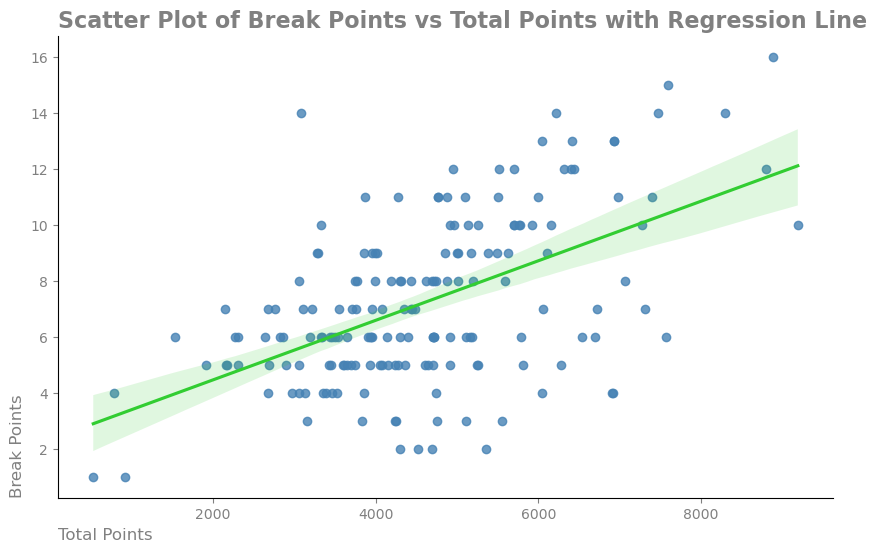

In [23]:



# محاسبه total_point برای هر match_id و game_id
p_by_p_dataframe['total_point'] = p_by_p_dataframe['home_point'] + p_by_p_dataframe['away_point']

# گروه‌بندی براساس match_id و game_id و جمع کردن امتیازات
p_by_p_grouped = p_by_p_dataframe.groupby(['match_id', 'game_id']).agg(
    total_point=('total_point', 'sum')
).reset_index()

# فیلتر کردن گیم‌هایی که break_occurred=True در جدول power_dataframe
power_filtered = power_dataframe[power_dataframe['break_occurred'] == True]

# ادغام دو جدول براساس match_id و game_id
merged_df = pd.merge(p_by_p_grouped, power_filtered, left_on=['match_id', 'game_id'], right_on=['match_id', 'game_num'], how='inner')


# فیلتر کردن گیم‌هایی که break_occurred=True در جدول power_dataframe
power_filtered = power_dataframe[power_dataframe['break_occurred'] == True]

# ادغام دو جدول براساس match_id و game_id
merged_df = pd.merge(p_by_p_grouped, power_filtered, left_on=['match_id', 'game_id'], right_on=['match_id', 'game_num'], how='inner')

# مرحله 1: محاسبه تعداد break points برای هر match_id
break_points_per_match = power_filtered.groupby('match_id').size().reset_index(name='break_points')

# مرحله 2: محاسبه مجموع total points برای هر match_id
total_points_per_match = p_by_p_dataframe.groupby('match_id')['total_point'].sum().reset_index()

# مرحله 3: ادغام دو جدول براساس match_id برای رسم نمودار
merged_df = pd.merge(total_points_per_match, break_points_per_match, on='match_id')

# مرحله 4: رسم نمودار scatter plot با خط رگرسیون
plt.figure(figsize=(10, 6), alpha = 0.8)

# رسم نمودار پراکندگی به همراه خط رگرسیون
sns.regplot(x='total_point', y='break_points', data=merged_df, scatter_kws={'color': '#4682b4'}, line_kws={'color': '#32cd32'})

# تنظیمات نمودار
plt.title('Scatter Plot of Break Points vs Total Points with Regression Line', fontsize=16, color='gray', loc='left', fontweight='bold')
plt.xlabel('Total Points', fontsize=12, color='gray', loc='left')
plt.ylabel('Break Points', fontsize=12, color='gray', loc='bottom')
# تغییر رنگ اعداد و خطوط مدرج به خاکستری
plt.tick_params(colors='gray')
# حذف حاشیه‌های راست و بالا
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

In [12]:
p_by_p_match_ids = set(p_by_p_dataframe['match_id'])
power_match_ids = set(power_dataframe['match_id'])


common_match_ids = p_by_p_match_ids.intersection(power_match_ids)
common_match_count = len(common_match_ids)

print(f"Number of common match_ids {common_match_count}")

Number of common match_ids 178


نموداری که رسم کرده‌ایم، رابطه بین تعداد **بریک_پوینت**  و مجموع **توتال_پوینت** برای هر مسابقه را نشان می‌دهد. خط رگرسیون سبز نشان می‌دهد که با افزایش تعداد **توتال_پوینت**، تعداد **بریک_پوینت** نیز تمایل به افزایش دارد. این ارتباط مثبت در خط رگرسیون قابل مشاهده است.

### تحلیل:
1. **رابطه مثبت:** خط رگرسیون شیب مثبتی دارد که نشان می‌دهد با افزایش تعداد کل امتیازات در یک مسابقه توتال_پوینت، احتمالاً تعداد بریک_پوینت نیز افزایش می‌یابد.
2. **پراکندگی داده‌ها:** برخی از نقاط در نمودار دور از خط رگرسیون هستند که نشان می‌دهد در برخی مسابقات رابطه بین **بریک_پوینت** و **توتال_پوینت** ممکن است خیلی دقیق نباشد. این نقاط می‌توانند به دلایل مختلفی رخ دهند، مانند تغییرات تاکتیکی بازیکنان یا شرایط مختلف مسابقه.
3. **رنج داده‌ها:** توتال_پوینت در حدود 1000 تا 8000 متغیر است، و بریک_پوینت نیز در اکثر موارد بین 2 تا 8 تغییر می‌کند. هرچند برخی نقاط پراکنده، خارج از این محدوده‌ها نیز وجود دارند که نشان می‌دهد برخی مسابقات با تعداد بالای بریک_پوینت یا امتیازهای کل زیاد مواجه شده‌اند.
4. **ناحیه اعتماد:** نوار سبز روشن اطراف خط رگرسیون نشان‌دهنده ناحیه اعتماد است. این ناحیه به شما نشان می‌دهد که چقدر عدم قطعیت در پیش‌بینی Break Points برای مقدارهای مختلف توتال_پوینت وجود دارد. به‌طور کلی، ناحیه اعتماد به خصوص در محدوده‌های پایین‌تر بیشتر است، اما با افزایش توتال_پوینت ناحیه باریک‌تر می‌شود که نشان می‌دهد پیش‌بینی Break Points برای مسابقات با امتیازات بالا دقیق‌تر است.

### نتیجه‌گیری:
به‌طور کلی، این نمودار نشان می‌دهد که تعداد کل امتیازات در یک مسابقه ممکن است به افزایش تعداد بریک_پوینت کمک کند، اما این رابطه همیشه دقیق نیست و بسته به مسابقه و بازیکنان ممکن است تغییرات زیادی داشته باشد.

اگر بخواهیم دقت بیشتری داشته باشیم، می‌توانیم این تحلیل را برای گروه‌های مختلف مسابقات (مثلاً بر اساس زمین یا جنسیت بازیکنان) تکرار کنیم تا بررسی کنیم آیا عوامل دیگری نیز بر این رابطه تأثیر می‌گذارند یا خیر.